In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import sklearn
import pandas as pd
import photutils

from skimage import data, img_as_float
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error

from photutils.detection import DAOStarFinder
from photutils.morphology import data_properties
from astropy.stats import mad_std

from tensorflow import keras
from tensorflow.keras import layers

from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose
from tensorflow.keras.layers import Input, Dense, Flatten, Lambda, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import mse

from tensorflow.config import list_logical_devices, list_physical_devices, set_visible_devices
from tensorflow.config.experimental import set_memory_growth




In [2]:
#Setup notebook so Tensorflow works in a friendly way in a shared multi GPU env

def setup_tensorflow(seed=None):
    try:
        import nvsmi

        gpu_mem_free = np.array([gpu.mem_free for gpu in nvsmi.get_gpus()])
        if len(gpu_mem_free) > 0 and (gpu_mem_free > 0).any():
            idx = np.argmax(gpu_mem_free)
            gpu = list_physical_devices("GPU")[idx]
            set_memory_growth(gpu, True)
            set_visible_devices(gpu, "GPU")
            gpus = list_logical_devices("GPU")
            print(f"Using GPU: {gpus}")
        else:
            raise Exception
    except:
        print(f"Tensorflow using CPU")
    tf.random.set_seed(seed)


In [3]:
#If working in a multiply GPU setup run setup_tensorflow()

#setup_tensorflow()

In [4]:
#load the image arrays, Size: (ngals, 64, 64), (2, ngals, 64, 64) respectively 

blends = np.load("central_blends.npy")
components = np.load("central_components.npy")
     

In [5]:
#Split into training and test set 

#Going to split training and test 80% and 20% respectively 

train_ngals = int(blends.shape[0] * 0.8)
test_ngals = int(blends.shape[0] * 0.2)

train_blends = blends[:train_ngals]
test_blends = blends[train_ngals:]

a, b, c, d, test_components = np.split(components, 5, axis = 1)
train_components = np.concatenate((a, b, c, d), axis = 1)





In [6]:
blends.shape, train_blends.shape, test_blends.shape

((30000, 64, 64), (24000, 64, 64), (6000, 64, 64))

In [7]:
components.shape, train_components.shape, test_components.shape

((2, 30000, 64, 64), (2, 24000, 64, 64), (2, 6000, 64, 64))

In [8]:

#Normalise the data

#Blends

train_blends_max = np.amax(train_blends)
train_blends_min = np.amin(train_blends)

train_blends = (train_blends - train_blends_min) / (train_blends_max - train_blends_min) 

test_blends_max = np.amax(test_blends)
test_blends_min = np.amin(test_blends)

test_blends = (test_blends - test_blends_min) / (test_blends_max - test_blends_min) 

#Components

train_components_max = np.amax(train_components) 
train_components_min = np.amin(train_components)

train_components = (train_components - train_components_min) / (train_components_max - train_components_min) 

test_components_max = np.amax(test_components) 
test_components_min = np.amin(test_components)

test_components = (test_components - test_components_min) / (test_components_max - test_components_min) 



In [9]:
np.amax(train_blends), np.amin(train_blends), np.amax(test_blends), np.amin(test_blends)

(1.0, 0.0, 1.0, 0.0)

In [10]:
np.amax(test_components), np.amin(test_components), np.amax(test_blends), np.amin(test_blends)

(1.0, 0.0, 1.0, 0.0)

In [11]:
height,width=64,64

train_blends = train_blends.reshape(train_ngals, height, width, 1).astype('float32')
train_components = train_components.reshape(2, train_ngals, height, width, 1).astype('float32')

test_blends = test_blends.reshape(test_ngals, height, width, 1).astype('float32')
test_components = test_components.reshape(2, test_ngals, height, width, 1).astype('float32')


In [12]:
batch_size = 32
latent_dimensions = 32

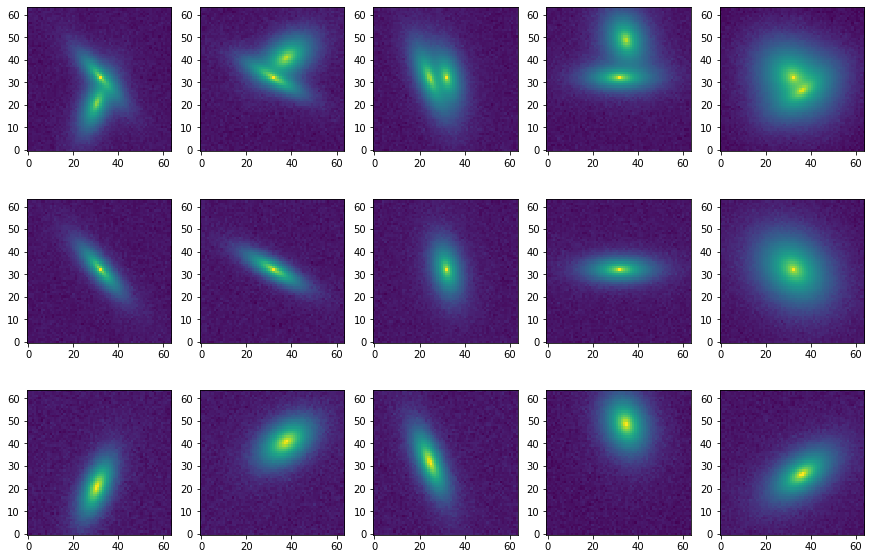

In [13]:
fig, ax = plt.subplots(components.shape[0] + 1, 5, figsize=(15, 10))
for i in range(5):
    ax[0, i].imshow(train_blends[i], origin='lower', interpolation='nearest')
    ax[1, i].imshow(train_components[0, i], origin='lower', interpolation='nearest')
    ax[2, i].imshow(train_components[1, i], origin='lower', interpolation='nearest')

In [14]:
#Will optimise encoder / decoder later
def encoder(x):
    x=Conv2D(32,3,activation='relu',padding='same', strides=2)(x)
    x=Conv2D(64,3,activation='relu',padding='same', strides=2)(x)
    return x

In [15]:
def decoder(x):
    #x=UpSampling2D()(x)
    x=Conv2DTranspose(64,3,activation='relu',padding='same', strides=2)(x)
    x=Conv2DTranspose(32,3,activation='relu',padding='same', strides=2)(x)
    return x

In [16]:
def sampling(args):
    z_mean,z_log_sigma=args
    epsilon=tf.random.normal(shape=tf.shape(z_mean))
    z=z_mean+tf.exp(0.5*z_log_sigma)*epsilon
    return z

In [17]:
# encoder
input_blend=Input(shape=(height, width,1))

encoded=encoder(input_blend)
shape=encoded.get_shape()[1:]
encoded=Flatten()(encoded)

z_mean=Dense(latent_dimensions)(encoded)
z_log_sigma=Dense(latent_dimensions)(encoded)
z=Lambda(sampling)([z_mean,z_log_sigma])

In [18]:
# decoder
input_embed=Input(shape=latent_dimensions)

embed1=Dense(np.prod(shape),activation='relu')(input_embed)
embed1=Reshape(shape)(embed1)
decoded1=decoder(embed1)
output1=Conv2DTranspose(1,3,padding='same')(decoded1)


In [19]:
encode=Model(input_blend,z)
encode.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 32)   320         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 16, 16, 64)   18496       ['conv2d[0][0]']                 
                                                                                                  
 flatten (Flatten)              (None, 16384)        0           ['conv2d_1[0][0]']               
                                                                                              

In [20]:
input_component1 = Input(shape=(height, width, 1))

decode=Model([input_embed, input_component1], [output1])
decode.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 32)]         0           []                               
                                                                                                  
 dense_2 (Dense)                (None, 16384)        540672      ['input_2[0][0]']                
                                                                                                  
 reshape (Reshape)              (None, 16, 16, 64)   0           ['dense_2[0][0]']                
                                                                                                  
 conv2d_transpose (Conv2DTransp  (None, 32, 32, 64)  36928       ['reshape[0][0]']                
 ose)                                                                                       

In [21]:
encoding = encode(input_blend)
re1 = decode([encoding, input_component1])

vae = Model([input_blend, input_component1], [re1])

In [22]:
vae.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 1)]  0           []                               
                                                                                                  
 model (Functional)             (None, 32)           1067456     ['input_1[0][0]']                
                                                                                                  
 input_3 (InputLayer)           [(None, 64, 64, 1)]  0           []                               
                                                                                                  
 model_1 (Functional)           (None, 64, 64, 1)    596353      ['model[0][0]',                  
                                                                  'input_3[0][0]']          

In [23]:
#In our loss we are only going to compare to the central image i.e component 1 

mse_loss = tf.reduce_mean(mse(input_component1,re1)) * height * width
vae.add_loss(mse_loss)
vae.add_metric(mse_loss, 'mse_loss')

beta = 0.1 
kl_loss=tf.reduce_mean(-0.5*(1+z_log_sigma-tf.square(z_mean)-tf.exp(z_log_sigma)))*beta
vae.add_loss(kl_loss)
vae.add_metric(kl_loss,'kl_loss')


train_together = [train_blends, train_components[0]]
test_together = [test_blends, test_components[0]]

#need an array which has the blends and both components for later use of calculating metrics - this will be using the test set 

metrics_together = [test_blends, test_components[0], test_components[1]]


vae.compile(optimizer=Adam())

In [24]:
val_split_ratio = 0.2 
print(val_split_ratio * train_ngals)

4800.0


In [25]:
#training
history=vae.fit(train_together, verbose=1, epochs=2, batch_size=batch_size, validation_split = val_split_ratio)

Epoch 1/2
600/600 [==============================] - 105s 172ms/step - loss: 2.6916 - mse_loss: 2.5437 - kl_loss: 0.1479 - val_loss: 1.5480 - val_mse_loss: 1.3837 - val_kl_loss: 0.1643
Epoch 2/2
600/600 [==============================] - 99s 165ms/step - loss: 1.4440 - mse_loss: 1.2839 - kl_loss: 0.1601 - val_loss: 1.2298 - val_mse_loss: 1.0789 - val_kl_loss: 0.1509


In [26]:
def histplot(history):
    plt.rcParams["figure.figsize"] = (10,7)
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(loss) + 1)
    plt.plot(epochs, loss, label = 'Training loss')
    plt.plot(epochs, val_loss, label = 'Validation loss')
    plt.axhline( y = min(val_loss), color = 'black', linestyle = 'dotted', label = f'Minimum Validation Loss: {min(val_loss):.4f}')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

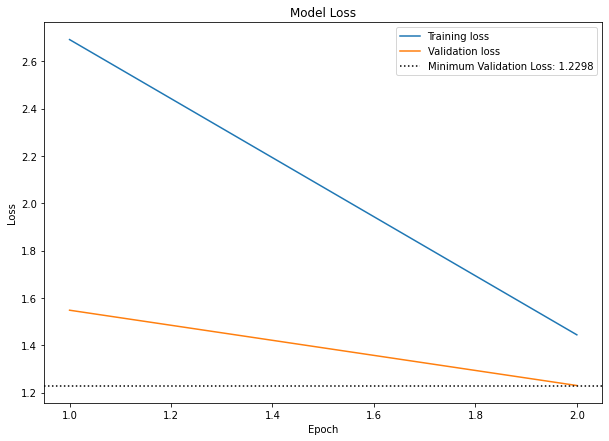

In [27]:
histplot(history)

In [28]:
def showimg(img, ax, title=None, vmin=0, vmax=1):
    ax.imshow(img.squeeze(), vmin=vmin, vmax=vmax)
    ax.set_title(title)
    ax.axis('off')



def summary_plot(n,inputs,decode,seed=1):
    np.random.seed(seed)
    #idx=np.array([0,1,2,3,4])
    idx = np.random.choice(len(inputs[0]), size=n, replace=False)
    print(idx)
    input_img = inputs[0][idx]
    #Comp 1 = Central Comp, Comp 2 = Residual
    comp1 = inputs[1][idx]
    comp2 = inputs[2][idx]
    z = encode.predict(input_img)
    output_img = decode.predict([z,comp1])
    comp1.shape, output_img.shape
    fig, ax = plt.subplots(6, n, figsize=((3)*n,15))
    for i in range(n):
        ax[0, i].imshow(input_img[i], origin='lower', interpolation='nearest', vmin = 0, vmax = 0.75)
        ax[0, i].set_title('Input Blend')
        ax[1, i].imshow(comp1[i], origin='lower', interpolation='nearest', vmin = 0, vmax = 0.75 )
        ax[1, i].set_title('Input Central Component')
        ax[2, i].imshow(comp2[i], origin='lower', interpolation='nearest', vmin = 0, vmax = 0.75 )
        ax[2, i].set_title('Input Component 2')
        ax[3, i].imshow(output_img[i], origin='lower', interpolation='nearest', vmin = 0, vmax = 0.75 )
        ax[3, i].set_title('Output Central Component')
        ax[4, i].imshow(input_img[i] - output_img[i], origin='lower', interpolation='nearest', vmin = 0, vmax = 0.75 )
        ax[4, i].set_title('Output Residual Component')
        ax[5, i].imshow(abs(comp1[i] - output_img[i]), origin='lower', interpolation='nearest', vmin = 0, vmax = 0.75 )
        ax[5, i].set_title('Central Component Difference')
        plt.tight_layout()
    return idx


[1483 2185 2520 3721 3727]


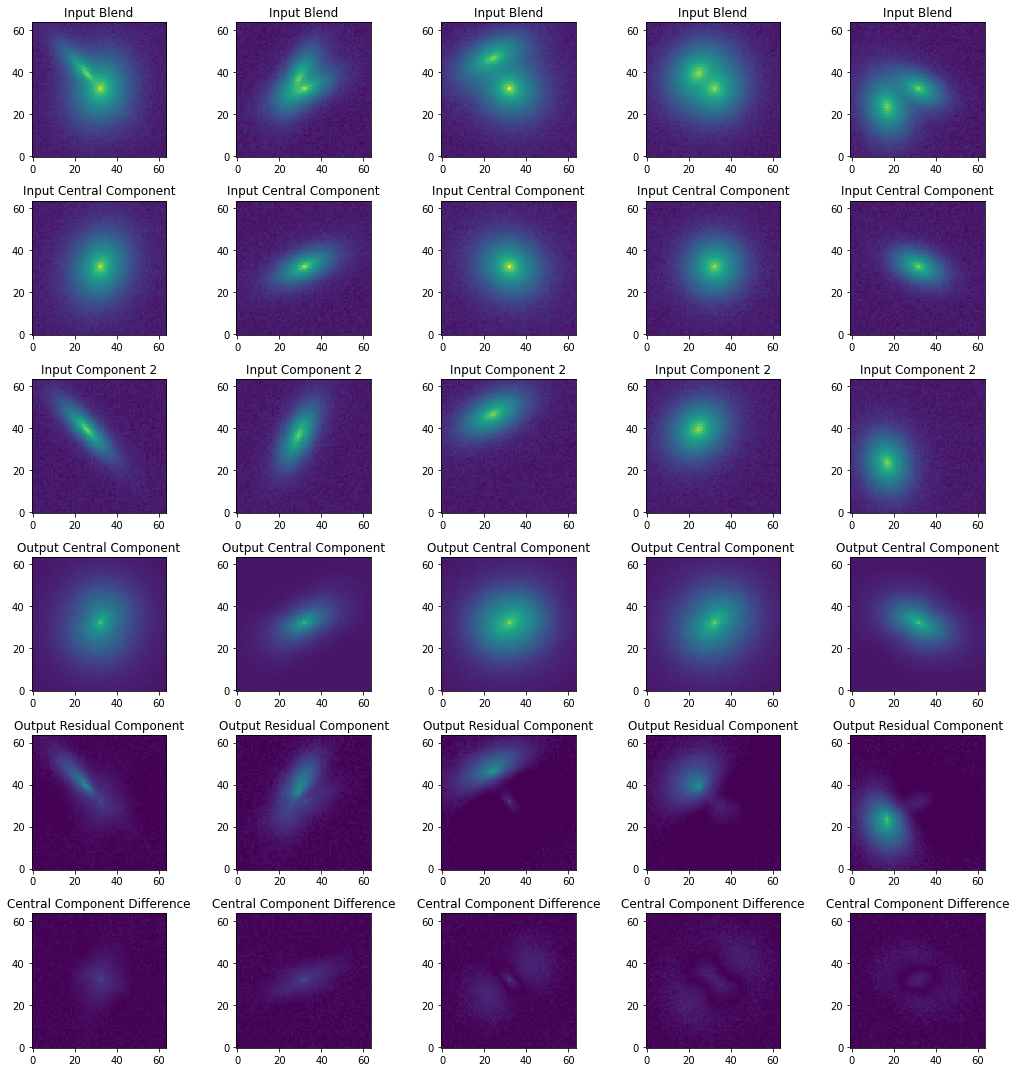

In [29]:
n=5
chosen=summary_plot(n,metrics_together,decode)

In [30]:
def calc_ssim(inputs,decode):
    ssim_comp1 = np.zeros(test_ngals)
    ssim_comp2 = ssim_comp1
    ssim_blends = ssim_comp1
    input_img = inputs[0]
    #Comp 1 = Central Comp, Comp 2 = Residual
    comp1 = inputs[1]
    comp2 = inputs[2]
    z = encode.predict(input_img)
    output_img1 = decode.predict([z, comp1])
    for i in range(test_ngals):
        ssim_comp1[i] = ssim(comp1[i], output_img1[i], channel_axis = 2)
        ssim_comp2[i] = ssim(comp2[i], (input_img[i] - output_img1[i]), channel_axis = 2)
    mean_ssim_comp1 = np.mean(ssim_comp1)
    median_ssim_comp1 = np.median(ssim_comp1)
    
    mean_ssim_comp2 = np.mean(ssim_comp2)
    median_ssim_comp2 = np.median(ssim_comp2)
    
    ssim_values = np.array([mean_ssim_comp1, median_ssim_comp1, mean_ssim_comp2, median_ssim_comp2 ])
    
    return ssim_values 
        
    
    

In [31]:
ssim_values = calc_ssim(metrics_together, decode)

In [32]:

mean_ssim_comp1 = ssim_values[0]
median_ssim_comp1 = ssim_values[1]
mean_ssim_comp2 = ssim_values[2]
median_ssim_comp2 = ssim_values[3]


In [33]:
print(f' Mean SSIMs: Central Component: {mean_ssim_comp1:.4f}, Residual Component: {mean_ssim_comp2:.4f}')

print(f' Median SSIMs: Central Component: {median_ssim_comp1:.4f}, Residual Component: {median_ssim_comp2:.4f} ')


 Mean SSIMs: Central Component: 0.3768, Residual Component: 0.3768
 Median SSIMs: Central Component: 0.3872, Residual Component: 0.3872 


In [34]:
#This function calculates the properties of the input and output images. The ellipticity and flux are stored in arrays 

def calc_properties(inputs,decode):
    
    empty_array = np.zeros(test_ngals)
    
    flux_in_comp1 = np.zeros(test_ngals)
    
    flux_out_comp1 = np.zeros(test_ngals)
    
    elip_in_comp1 = np.zeros(test_ngals)
    
    elip_out_comp1 = np.zeros(test_ngals)
    
    flux_in_comp2 = np.zeros(test_ngals)
    
    flux_out_comp2 = np.zeros(test_ngals)
    
    elip_in_comp2 = np.zeros(test_ngals)

    elip_out_comp2 = np.zeros(test_ngals)
    
    input_img = inputs[0]
    input_img = input_img.reshape(test_ngals, height, width)
    comp1 = inputs[1]
    comp1 = comp1.reshape(test_ngals, height, width)
    comp2 = inputs[2]
    comp2 = comp2.reshape(test_ngals, height, width)
    
    z = encode.predict(input_img)
    output_img1 = decode.predict([z, comp1])
    output_img1 = output_img1.reshape(test_ngals, height, width)
    
    for i in range(test_ngals):
        
        in_comp1_cat = photutils.morphology.data_properties(comp1[i], mask = None, background = 0)
        elip_in_comp1[i] = in_comp1_cat.ellipticity
        flux_in_comp1[i] = in_comp1_cat.segment_flux
            
        out_comp1_cat = photutils.morphology.data_properties(output_img1[i], mask = None, background = 0)
        elip_out_comp1[i] = out_comp1_cat.ellipticity
        flux_out_comp1[i] = out_comp1_cat.segment_flux
        
        in_comp2_cat = photutils.morphology.data_properties(comp2[i], mask = None, background = 0)
        elip_in_comp2[i] = in_comp2_cat.ellipticity
        flux_in_comp2[i] = in_comp2_cat.segment_flux
            
        out_comp2_cat = photutils.morphology.data_properties(input_img[i] - output_img1[i], mask = None, background = 0)
        elip_out_comp2[i] = out_comp2_cat.ellipticity
        flux_out_comp2[i] = out_comp2_cat.segment_flux
        
        parameters = [elip_in_comp1, elip_out_comp1, flux_in_comp1, flux_out_comp1, elip_in_comp2, elip_out_comp2, flux_in_comp2, flux_out_comp2]   
    return parameters


        

In [35]:
parameters = calc_properties(metrics_together, decode)

In [36]:

ellip_in_comp1 = parameters[0]
ellip_out_comp1 = parameters[1]
flux_in_comp1 = parameters[2]
flux_out_comp1 = parameters[3]
ellip_in_comp2 = parameters[4]
ellip_out_comp2 = parameters[5]
flux_in_comp2 = parameters[6]
flux_out_comp2 = parameters[7]



In [37]:
#Calculate the standard deviations 
def calc_std(parameters):
    num_of_params = len(parameters)
    standard_dev_of_params = np.zeros(num_of_params)
    for i in range(0,num_of_params):
        standard_dev_of_params[i] = np.std(parameters[i])
    return standard_dev_of_params



In [38]:
std_of_params = calc_std(parameters)

print(std_of_params)



[3.37128711e-02 4.22538535e-02 8.76669008e+01 9.26536879e+01
 3.46861700e-02 9.70846445e-02 8.55919903e+01 4.44982779e+01]


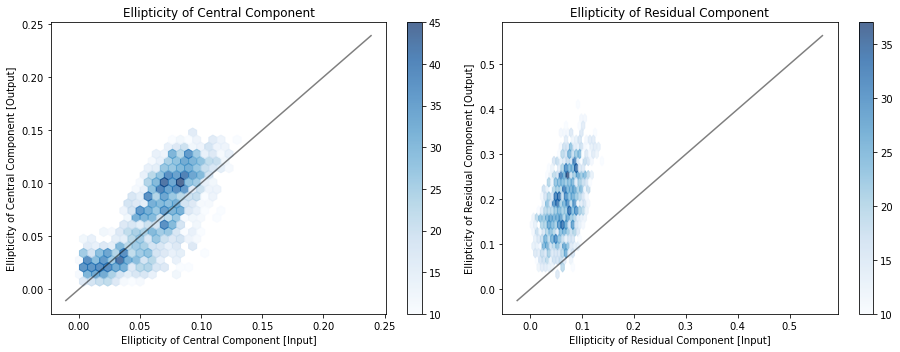

In [39]:

fig, axes = plt.subplots(1, 2, figsize = (13,5))

axes[0].set_title("Ellipticity of Central Component")
hex1 = axes[0].hexbin(ellip_in_comp1, ellip_out_comp1, gridsize=30, cmap='Blues', mincnt=10, alpha=0.7)
axes[0].set_xlabel("Ellipticity of Central Component [Input]")
axes[0].set_ylabel("Ellipticity of Central Component [Output]")
fig.colorbar(hex1, ax=axes[0])

lims = [
    np.min([axes[0].get_xlim(), axes[0].get_ylim()]),  # min of both axes
    np.max([axes[0].get_xlim(), axes[0].get_ylim()]),  # max of both axes
]


# now plot both limits against eachother
axes[0].plot(lims, lims, 'k-', alpha=0.5, zorder=1)

axes[1].set_title("Ellipticity of Residual Component")
hex2 = axes[1].hexbin(ellip_in_comp2, ellip_out_comp2, gridsize=30, cmap='Blues', mincnt=10, alpha=0.7)
axes[1].set_xlabel("Ellipticity of Residual Component [Input]")
axes[1].set_ylabel("Ellipticity of Residual Component [Output]")
fig.colorbar(hex2, ax=axes[1])

lims = [
    np.min([axes[1].get_xlim(), axes[1].get_ylim()]),  # min of both axes
    np.max([axes[1].get_xlim(), axes[1].get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
axes[1].plot(lims, lims, 'k-', alpha=0.5, zorder=1)


fig.tight_layout()

plt.show()


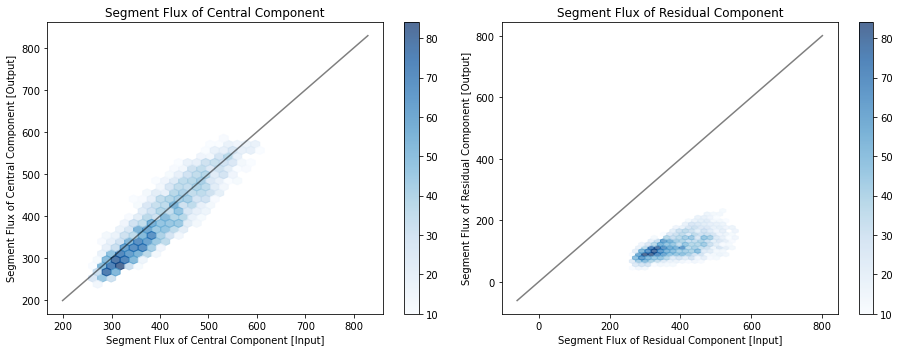

In [40]:
fig, axes = plt.subplots(1, 2, figsize = (13,5))

axes[0].set_title("Segment Flux of Central Component")
hex1 = axes[0].hexbin(flux_in_comp1, flux_out_comp1, gridsize=30, cmap='Blues', mincnt=10, alpha=0.7)
axes[0].set_xlabel("Segment Flux of Central Component [Input]")
axes[0].set_ylabel("Segment Flux of Central Component [Output]")
fig.colorbar(hex1, ax=axes[0])

lims = [
    np.min([axes[0].get_xlim(), axes[0].get_ylim()]),  # min of both axes
    np.max([axes[0].get_xlim(), axes[0].get_ylim()]),  # max of both axes
]


# now plot both limits against eachother
axes[0].plot(lims, lims, 'k-', alpha=0.5, zorder=1)

axes[1].set_title("Segment Flux of Residual Component")
hex2 = axes[1].hexbin(flux_in_comp2, flux_out_comp2, gridsize=30, cmap='Blues', mincnt=10, alpha=0.7)
axes[1].set_xlabel("Segment Flux of Residual Component [Input]")
axes[1].set_ylabel("Segment Flux of Residual Component [Output]")
fig.colorbar(hex2, ax=axes[1])

lims = [
    np.min([axes[1].get_xlim(), axes[1].get_ylim()]),  # min of both axes
    np.max([axes[1].get_xlim(), axes[1].get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
axes[1].plot(lims, lims, 'k-', alpha=0.5, zorder=1)


fig.tight_layout()

plt.show()

In [41]:


# abs(Output / Input) * 100

ellip_comp1_accuracy = abs(ellip_out_comp1 / ellip_in_comp1) * 100
mean_ellip_comp1_accuracy = np.mean(ellip_comp1_accuracy)
median_ellip_comp1_accuracy = np.median(ellip_comp1_accuracy)


flux_comp1_accuracy = abs(flux_out_comp1 / flux_in_comp1) * 100
mean_flux_comp1_accuracy = np.mean(flux_comp1_accuracy)
median_flux_comp1_accuracy = np.median(flux_comp1_accuracy)


ellip_comp2_accuracy = abs(ellip_out_comp2 / ellip_in_comp2) * 100
mean_ellip_comp2_accuracy = np.mean(ellip_comp2_accuracy)
median_ellip_comp2_accuracy = np.median(ellip_comp2_accuracy)


flux_comp2_accuracy = abs(flux_out_comp2 / flux_in_comp2) * 100
mean_flux_comp2_accuracy = np.mean(flux_comp2_accuracy)
median_flux_comp2_accuracy = np.median(flux_comp2_accuracy)





In [42]:
print(f' Mean ellipticity accuracys: Central Component: {mean_ellip_comp1_accuracy :.4f}, Residual Component: {mean_ellip_comp2_accuracy:.4f}')
print(f' Median ellipticity accuracys: Central Component: {median_ellip_comp1_accuracy:.4f}, Residual Component: {median_ellip_comp2_accuracy:.4f}')

 Mean ellipticity accuracys: Central Component: 141.9121, Residual Component: 420.7270
 Median ellipticity accuracys: Central Component: 112.4980, Residual Component: 291.6275


In [43]:
print(f' Mean flux accuracys: Central Component: {mean_flux_comp1_accuracy:.4f}, Residual Component: {mean_flux_comp2_accuracy}')
print(f' Median flux accuracys: Central Component: {median_flux_comp1_accuracy:.4f}, Residual Component: {median_flux_comp2_accuracy:.4f}')

 Mean flux accuracys: Central Component: 99.2603, Residual Component: 29.82084329690367
 Median flux accuracys: Central Component: 97.5593, Residual Component: 29.5918
